In [1]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import scipy
from NMF_Function import myNMF
import pyaudio
from playsound import playsound
import sounddevice as sd



In [2]:
# # Training Speech dictionary
# x, sr = librosa.load("joe1.wav", sr=None) # Loading in audio file

# # Calculating the spectrogram of the audio file
# S = librosa.stft(x,hop_length=256,win_length=1024, window='hamming', n_fft=1024)
# S_mag, S_phase = librosa.magphase(S)
# S_db = librosa.amplitude_to_db(S_mag)

# # NMF Parameters
# r = 1
# nIter = 50

# [W_Joe1,H_Joe1,KL] = myNMF(S_mag,r,nIter)

# # Training Speech dictionary
# x, sr = librosa.load("joe2.wav", sr=None) # Loading in audio file

# # Calculating the spectrogram of the audio file
# S = librosa.stft(x,hop_length=256,win_length=1024, window='hamming', n_fft=1024)
# S_mag, S_phase = librosa.magphase(S)
# S_db = librosa.amplitude_to_db(S_mag)

# # NMF Parameters
# r = 1
# nIter = 50


# [W_Joe2,H_Joe2,KL] = myNMF(S_mag,r,nIter)

# x, sr = librosa.load("joe3.wav", sr=None) # Loading in audio file

# # Calculating the spectrogram of the audio file
# S = librosa.stft(x,hop_length=256,win_length=1024, window='hamming', n_fft=1024)
# S_mag, S_phase = librosa.magphase(S)
# S_db = librosa.amplitude_to_db(S_mag)

# # NMF Parameters
# r = 1
# nIter = 50

# [W_Joe3,H_Joe3,KL] = myNMF(S_mag,r,nIter)

# W_Joe = np.concatenate((W_Joe1,W_Joe2,W_Joe3),axis=1)

print("Training Dictionary")
W = np.zeros((513,3))
for comp in range(3):
    x, sr = librosa.load(f'joe{comp+1}.wav', sr=None) # Loading in audio file
    

    # Calculating the spectrogram of the audio file
    S = librosa.stft(x,hop_length=256,win_length=1024, window='hamming', n_fft=1024)
    S_mag, S_phase = librosa.magphase(S)
    S_db = librosa.amplitude_to_db(S_mag)

    # NMF Parameters
    r = 1
    nIter = 75

    [W_temp,H,KL] = myNMF(S_mag,r,nIter)
    
    print(f'Component {comp} Trained')





Training Dictionary
Component 0 Trained
Component 1 Trained
Component 2 Trained


In [7]:
W[:,0] = W_temp[:,0]

In [28]:

x, sr = librosa.load("joetest.wav", sr=None) # Loading in audio file

# Calculating the spectrogram of the audio file
S = librosa.stft(x,hop_length=256,win_length=1024, window='hamming', n_fft=1024)
S_mag, S_phase = librosa.magphase(S)
S_db = librosa.amplitude_to_db(S_mag)

# NMF Parameters
r = 3
nIter = 100

[W_Combo,H,KL] = myNMF(S_mag,r,nIter,bUpdateW=0,initW=W)


Text(0, 0.5, 'Frequency (Hz)')

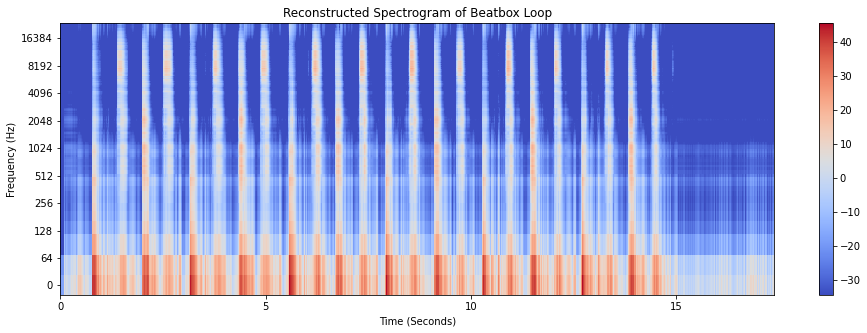

In [87]:
Y_beatbox = np.dot(W_Combo,H) # Reconstructed Spectrogram
y_beatbox = librosa.istft(Y_beatbox * S_phase, length = len(x) - 500, hop_length=256, win_length= 2048, n_fft=2048) # Inverse STFT 

plt.figure(figsize=(16, 5))
Y_db = librosa.amplitude_to_db(Y_beatbox)
librosa.display.specshow(Y_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Reconstructed Spectrogram of Beatbox Loop")
plt.xlabel("Time (Seconds)")
plt.ylabel("Frequency (Hz)")



# Saving separated reconstructions

# snd.write('noise_sep.wav',y_SepNoise,sr,subtype='PCM_16')

In [7]:
for n in range(r):
    
    # Re-create the STFT of a single NMF component.
    Y = np.outer(W_Combo[:,n], H[n])*S_phase
    
    # Transform the STFT into the time domain.
    y = librosa.istft(Y)
    
    print('Component {}:'.format(n))
    display(Audio(data=y, rate=sr))

Component 0:


Component 1:


Component 2:


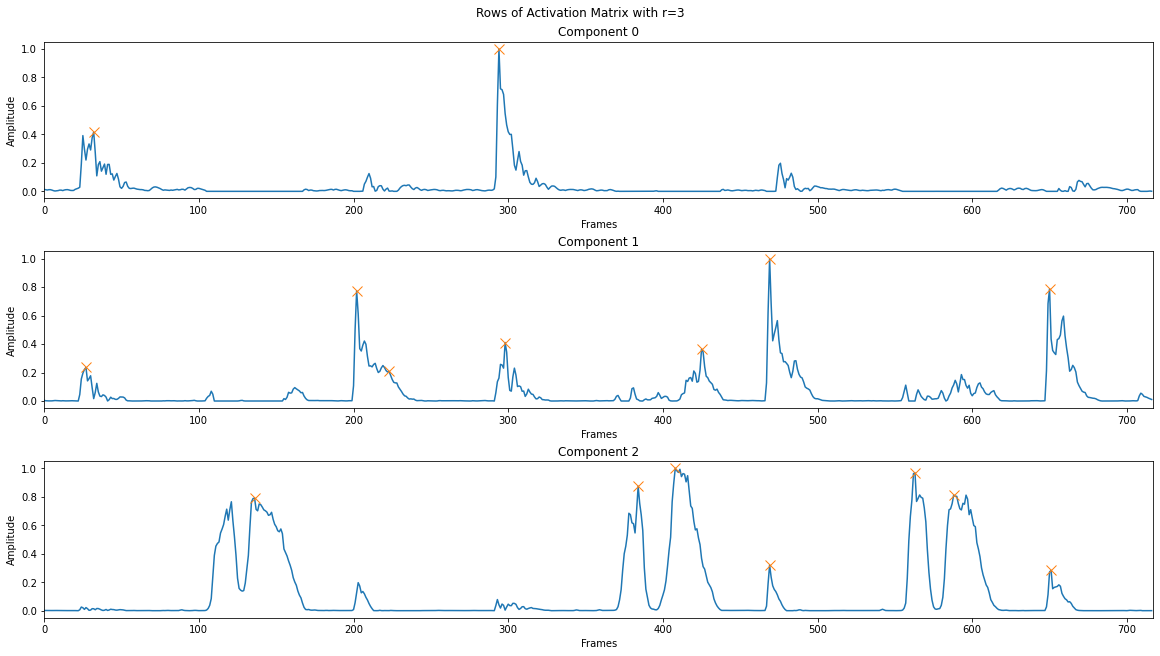

In [34]:
 # Scaling the activation matrix
# Plotting the activation matrix
fig, ax = plt.subplots(3,1,constrained_layout=True, figsize=(16,9))
fig.suptitle("Rows of Activation Matrix with r=3")
axes = ax.flat
localmax = np.zeros((3,100), dtype= int)



for n in range(r):

    H[n,:] *= 1.0 / (H[n,:].max())
    maxima, _ = scipy.signal.find_peaks(H[n,:], height=0.2, distance=20)
    localmax[n, 0:len(maxima)] = maxima
    axes[n].plot(H[n,:])
    axes[n].plot(maxima, H[n,maxima],'x',ms=10)
    axes[n].set_xlim(0, H.shape[1])
    axes[n].set_title('Component %d' % n)
    axes[n].set_xlabel('Frames')
    axes[n].set_ylabel('Amplitude')
    



In [30]:
maximas = np.concatenate([localmax[0],localmax[1],localmax[2]])
maximas = maximas[maximas != 0]
maximas = np.sort(maximas)

In [31]:
for i in range(0,len(maximas)-1):
    if(maximas[i+1] <= maximas[i] + 10):
        idx1 = np.where(localmax == maximas[i])[0][0]
        idx2 = np.where(localmax == maximas[i+1])[0][0]

        if(H[idx1,maximas[i]] > H[idx2,maximas[i+1]]):
            localmax[idx2, np.where(localmax[idx2] == maximas[i+1])[0]] = 0
        else:
            localmax[idx1,np.where(localmax[idx1] == maximas[i])[0]] = 0

        

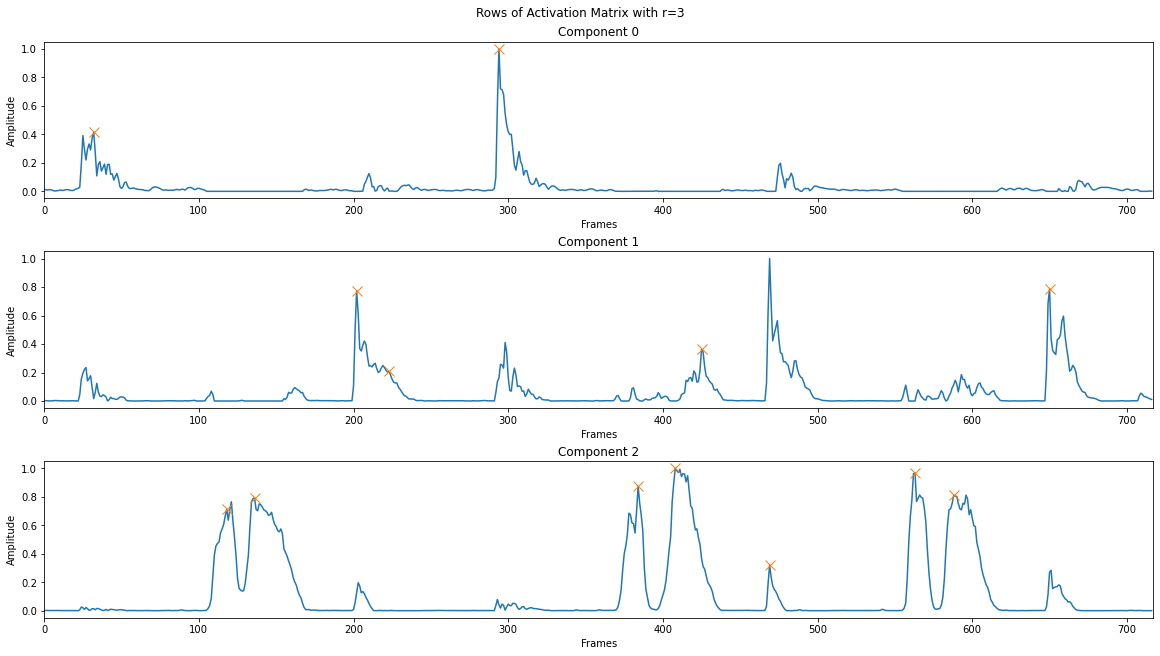

In [32]:
fig, ax = plt.subplots(3,1,constrained_layout=True, figsize=(16,9))
fig.suptitle("Rows of Activation Matrix with r=3")
axes = ax.flat

numframes = np.floor(x.size/256).astype(int)

triggers = np.zeros((3,numframes),dtype=int)
temps = np.zeros((3,100), dtype= int)
triggers_upsampled = np.zeros((3,numframes*2 - 1), dtype=int)

for n in range(r):
    max = localmax[n][localmax[n] != 0]
    temps[n, 0:len(max)] = max
    H[n,:] *= 1.0 / (H[n,:].max())
    
    axes[n].plot(H[n,:])
    axes[n].plot(max,H[n,max],'x',ms=10)
    axes[n].set_xlim(0, H.shape[1])
    axes[n].set_title('Component %d' % n)
    axes[n].set_xlabel('Frames')
    axes[n].set_ylabel('Amplitude')
    

    for i in range(numframes):
        if(i in max):
            triggers[n,i] = 1
    
    



In [12]:
snare, _ = librosa.load("Fakie Flip Snare.wav", sr=None) # Loading in audio file
kick, _ = librosa.load("Nollie Kick.wav", sr=None) # Loading in audio file
hihat, _ = librosa.load("Heel Flip Hat.wav", sr=None) # Loading in audio file

In [13]:

test = np.zeros((3,len(triggers[0]) + (len(triggers[0])-1)*(255)))
for n in range(3):
    test[n][::256] = triggers[n]

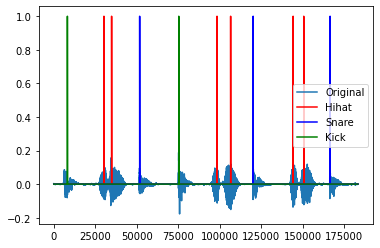

In [15]:
plt.plot(x)
plt.plot(test[2],'r')
plt.plot(test[1], 'b')
plt.plot(test[0], 'g')
plt.legend(["Original","Hihat","Snare","Kick"])

In [18]:
out = np.zeros(len(test[0])+93000)

for samp in range(len(test[0])):
    if(test[1,samp] == 1):
        out[samp:len(snare)+samp] = snare
    elif(test[0,samp] == 1):
        out[samp:len(kick)+samp] = kick
    elif(test[2,samp] == 1):
        out[samp:len(hihat)+samp] = hihat



In [58]:
triggers[:,1]

array([0, 0, 0])

In [ ]:
len(test[0])

417025

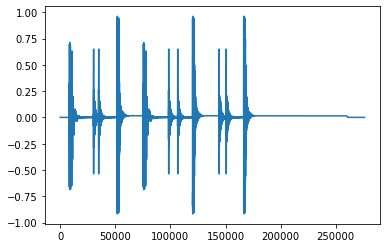

In [30]:
plt.plot(out)

In [19]:
if(x.size < out.size):
    out = out[0:len(x)]

Audio(data=out+x, rate=44100)

In [107]:
x, sr = librosa.load("beatboxtest.wav", sr=None) # Loading in audio file

In [23]:
import time
# constants
CHUNK = 256                  # samples per frame
FORMAT = pyaudio.paFloat32     # audio format (bytes per sample?)
CHANNELS = 1                 # single channel for microphone
RATE = 44100                 # samples per second
RECORD_SEC = 2

# pyaudio class instance
p = pyaudio.PyAudio()

# initialize stream object
stream = p.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    output=True,
    frames_per_buffer=CHUNK
)

## KICK
frames = [] # A python-list of chunks(numpy.ndarray)
while True:

    print('~~~~~~~~~~~~~~~~~~~~')
    print('Press Enter to begin recording Kick')
    input()

    
    time.sleep(.5)

    for _ in range(0, int(RATE / CHUNK * RECORD_SEC)):
        data = stream.read(CHUNK, exception_on_overflow = False)
        frames.append(np.fromstring(data, dtype=np.float32))

    
    playsound('record_end.wav')
    #Convert the list of numpy-arrays into a 1D array (column-wise)
    kick = np.hstack(frames)
    
    print('Playing back...')
    time.sleep(1)
    sd.play(kick, RATE)
    time.sleep(RECORD_SEC)
    sd.stop()

    
    check = input("Is this good? (Y/N)")
    if check == 'Y':
        print('\n')
        print('Kick recorded!')
        print('Press Enter to move onto Snare')
        print('~~~~~~~~~~~~~~~~~~~~')
        input()
        
        break
    else:
        frames = []
        print('\n\n')
        continue



~~~~~~~~~~~~~~~~~~~~
Press Enter to begin recording Kick


C:\Users\Gaboo Egset\AppData\Local\Temp\ipykernel_3092\2508512592.py:35: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  frames.append(np.fromstring(data, dtype=np.float32))


Playing back...



~~~~~~~~~~~~~~~~~~~~
Press Enter to begin recording Kick
Playing back...


Kick recorded!
Press Enter to move onto Snare
~~~~~~~~~~~~~~~~~~~~


In [24]:

## SNARE
frames = [] # A python-list of chunks(numpy.ndarray)
while True:

    print('~~~~~~~~~~~~~~~~~~~~')
    print('Press Enter to begin recording Snare')
    input()

    
    time.sleep(.5)

    for _ in range(0, int(RATE / CHUNK * RECORD_SEC)):
        data = stream.read(CHUNK, exception_on_overflow = False)
        frames.append(np.fromstring(data, dtype=np.float32))

    

    #Convert the list of numpy-arrays into a 1D array (column-wise)
    snare = np.hstack(frames)
    playsound('record_end.wav')
    print('Playing back...')
    time.sleep(1)
    sd.play(snare, RATE)
    time.sleep(RECORD_SEC)
    sd.stop()

    
    check = input("Is this good? (Y/N)")
    if check == 'Y':
        print('\n')
        print('Snare recorded!')
        print('Press Enter to move onto Hihat')
        print('~~~~~~~~~~~~~~~~~~~~')

        input()
        
        break
    else:
        frames = []
        print('\n\n')
        continue



## HIHAT
frames = [] # A python-list of chunks(numpy.ndarray)
while True:

    print('~~~~~~~~~~~~~~~~~~~~')
    print('Press Enter to begin recording Hihat')
    input()

    
    time.sleep(.5)

    for _ in range(0, int(RATE / CHUNK * RECORD_SEC)):
        data = stream.read(CHUNK, exception_on_overflow = False)
        frames.append(np.fromstring(data, dtype=np.float32))


    #Convert the list of numpy-arrays into a 1D array (column-wise)
    hihat = np.hstack(frames)
    playsound('record_end.wav')
    print('Playing back...')
    time.sleep(1)
    sd.play(hihat, RATE)
    time.sleep(RECORD_SEC)
    sd.stop()

    
    check = input("Is this good? (Y/N)")
    if check == 'Y':
        print('\n')
        print('Hihat recorded!')
        print('Press Enter to complete recording')
        print('~~~~~~~~~~~~~~~~~~~~')
        input()
        
        break
    else:
        frames = []
        print('\n\n')
        continue

print('Recording Done')

# close stream
stream.stop_stream()
stream.close()

p.terminate()



~~~~~~~~~~~~~~~~~~~~
Press Enter to begin recording Snare


C:\Users\Gaboo Egset\AppData\Local\Temp\ipykernel_3092\2897950949.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  frames.append(np.fromstring(data, dtype=np.float32))


Playing back...


Snare recorded!
Press Enter to move onto Hihat
~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~
Press Enter to begin recording Hihat


C:\Users\Gaboo Egset\AppData\Local\Temp\ipykernel_3092\2897950949.py:58: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  frames.append(np.fromstring(data, dtype=np.float32))


Playing back...


Hihat recorded!
Press Enter to complete recording
~~~~~~~~~~~~~~~~~~~~
Recording Done


In [26]:



# STFT Parameters
fftlen = 1024
hopsize = 256

# Training the dictionary components
print("Training Dictionary")

W = np.zeros((513,3)) # Dictionary Matrix

# Calculate the spectrogram
S = librosa.stft(kick,hop_length=hopsize,win_length=fftlen, window='hamming', n_fft=fftlen)
S_mag, S_phase = librosa.magphase(S)
S_db = librosa.amplitude_to_db(S_mag)

# NMF Parameters
r = 1
nIter = 75

[W_temp,H,KL] = myNMF(S_mag,r,nIter) # Process the Dictionary Matrix
W[:,0] = W_temp[:,0]

print(f'Component 0 Trained')


# Calculate the spectrogram
S = librosa.stft(snare,hop_length=hopsize,win_length=fftlen, window='hamming', n_fft=fftlen)
S_mag, S_phase = librosa.magphase(S)
S_db = librosa.amplitude_to_db(S_mag)

# NMF Parameters
r = 1
nIter = 75

[W_temp,H,KL] = myNMF(S_mag,r,nIter) # Process the Dictionary Matrix
W[:,1] = W_temp[:,0]

print(f'Component 1 Trained')


# Calculate the spectrogram
S = librosa.stft(hihat,hop_length=hopsize,win_length=fftlen, window='hamming', n_fft=fftlen)
S_mag, S_phase = librosa.magphase(S)
S_db = librosa.amplitude_to_db(S_mag)

# NMF Parameters
r = 1
nIter = 75

[W_temp,H,KL] = myNMF(S_mag,r,nIter) # Process the Dictionary Matrix
W[:,2] = W_temp[:,0]

print(f'Component 2 Trained')



Training Dictionary
Component 0 Trained
Component 1 Trained
Component 2 Trained


In [27]:


# Loading in Test Audio File
x, sr = librosa.load("joetest.wav", sr=None) # Loading in audio file

# Calculating the spectrogram of the audio file
S = librosa.stft(x,hop_length=hopsize,win_length=fftlen, window='hamming', n_fft=fftlen)
S_mag, S_phase = librosa.magphase(S)
S_db = librosa.amplitude_to_db(S_mag)

# NMF Parameters
r = 3
nIter = 100


[_,H,KL] = myNMF(S_mag,r,nIter,bUpdateW=0,initW=W) # Processing the audio file
print("NMF Completed")


numframes = np.floor(x.size/hopsize).astype(int) # calculating the number of total frames

localmax = np.zeros((3,100), dtype= int) # Variable for the local maxima of each component's activation matrix

for n in range(r):

    H[n,:] *= 1.0 / (H[n,:].max()) # Normalization

    maxima, _ = scipy.signal.find_peaks(H[n,:], height=0.2, distance=18) # Finding local maxima
    localmax[n, 0:len(maxima)] = maxima
    
# Organizing and sorting local maxima into one array
maximas = np.concatenate([localmax[0],localmax[1],localmax[2]])
maximas = maximas[maximas != 0]
maximas = np.sort(maximas)

# Detecting and processing duplicate or false maxima detection
for i in range(0,len(maximas)-1):

    # If any successive maxima are within a certain distance
    if(maximas[i+1] <= maximas[i] + 10): 

        idx1 = np.where(localmax == maximas[i])[0][0]
        idx2 = np.where(localmax == maximas[i+1])[0][0]

        # Check which maxima has a higher magnitude and delete the other false maxima
        if(H[idx1,maximas[i]] > H[idx2,maximas[i+1]]):
            localmax[idx2, np.where(localmax[idx2] == maximas[i+1])[0]] = 0
        else:
            localmax[idx1,np.where(localmax[idx1] == maximas[i])[0]] = 0



# Arrays for finding final triggers
triggers = np.zeros((3,numframes),dtype=int)
temps = np.zeros((3,100), dtype= int) 

for n in range(r):

    max = localmax[n][localmax[n] != 0] # Find all maxima not equal to 0
    temps[n, 0:len(max)] = max # Load into temp array

    for i in range(numframes): # Set impulse at maxima location
        if(i in max):
            triggers[n,i] = 1


snare, _ = librosa.load("Fakie Flip Snare.wav", sr=None) # Loading in audio file
kick, _ = librosa.load("Nollie Kick.wav", sr=None) # Loading in audio file
hihat, _ = librosa.load("Heel Flip Hat.wav", sr=None) # Loading in audio file



triggers_interp = np.zeros((3,len(triggers[0]) + (len(triggers[0])-1)*(255))) # Reconstructing the output through interpolation
for n in range(3):
    triggers_interp[n][::256] = triggers[n]

out = np.zeros(len(triggers_interp[0]) + RATE * RECORD_SEC) # Output with a buffer at the end for audio recording

# Check for trigger and load corresponding audio sample
for samp in range(len(triggers_interp[0])):
    if(triggers_interp[1,samp] == 1):
        out[samp:len(snare)+samp] = snare
    elif(triggers_interp[0,samp] == 1):
        out[samp:len(kick)+samp] = kick
    elif(triggers_interp[2,samp] == 1):
        out[samp:len(hihat)+samp] = hihat

if(x.size < out.size): # Match lengths of audio signals
    out = out[0:len(x)]

print("Playing Audio")

while True: # Play output 
    
    sd.play(out+x, RATE)
    time.sleep(len(out)/RATE)
    sd.stop()

    check = input("Is this good? (Y/N)")
    if check == 'Y':
        input()
        break

NMF Completed
Playing Audio


In [4]:
kick

array([ 0.0000000e+00,  0.0000000e+00, -3.0517578e-05, ...,
        7.0190430e-04,  7.9345703e-04,  7.9345703e-04], dtype=float32)